In [3]:
import os
import pandas as pd
import plotly.express as px

# Load Data

## Import data

L'idée est de faire un script global permettant de lire, concatener et créer un seul DataFrame pour chaque jeu de données récoltées.

Chaque fichier XLSX contient plusieurs lignes explicatives au début, alors nous les retirons lors de la lecture des fichier. Les fichiers excels ont aussi une feuille par région

Nous analysons d'abord la srtucture des fichiers xlsl pour pouvoir ensuite les organiser en dataframe

In [186]:
def load_perennite_data(path, skiprows, year):
    files = [f for f in os.listdir(path) if f.endswith((".xls", ".xlsx"))]
    df_list = []

    for f in files:
        file_path = os.path.join(path, f)
        xls = pd.ExcelFile(file_path)

        for sheet in xls.sheet_names:
            data = pd.read_excel(xls, sheet_name=sheet, skiprows=skiprows)
            data = data.iloc[:-4]  # remove footer

            categorie_type = data.iloc[0, 1]
            data = data.iloc[1:, :]

            # Rename columns
            data = data.rename(columns={
                data.columns[0]: "gender",
                data.columns[1]: "categories",
                data.columns[2]: "years"
            })

            # Forward-fill categorical columns
            data[["gender", "categories", "years"]] = data[["gender", "categories", "years"]].ffill()

            # Add metadata
            data["file_name"] = f
            data["area"] = sheet
            data["categorie_type"] = categorie_type
            data["year_source"] = year

            df_list.append(data)

    df_all = pd.concat(df_list, ignore_index=True)
    df_all = df_all[['gender', 'categorie_type'] + [col for col in df_all.columns if col not in ['gender', 'categorie_type']]]

    df_all.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)

    return df_all


In [185]:
df_2014 = load_perennite_data("../../data/all/2014-3-5/sine20143-perennite_xlsx", skiprows=3, year=2014)
df_2018 = load_perennite_data("../../data/all/2018-3-5/irecomicroent2018_1_perennite_xlsx", skiprows=5, year=2018)

C:\Users\angel\AppData\Local\Temp\ipykernel_45784\120333104.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_45784\120333104.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)


In [76]:
df_2014["categorie_type"].unique()

array(['Catégorie juridique', "Secteur d'activité",
       "Nature de l'entreprise, filiale ou non",
       'Âge du créateur en 2014',
       "Qualification de l'emploi antérieur du créateur",
       'Situation antérieure à la création',
       'Diplôme le plus élevé en 2014', 'Motivations à la création',
       'Nombre de créations ou reprises avant 2014',
       'Participation à une formation particulière pour la\nréalisation du projet',
       "Bénéfice d'aides ou d'exonérations publiques",
       'Moyens financiers nécessaires pour démarrer',
       'Emploi de salariés au démarrage',
       "Effectif salarié de l'entreprise au démarrage",
       "Avis du créateur sur l'avenir de l'entreprise",
       'Situation familiale du créateur en 2014',
       "Introduction d'innovation en marketing",
       'Introduction de procédés de fabrication nouveaux',
       "Introduction de modes d'organisation nouveaux",
       'Introduction de produits ou services nouveaux',
       'Principales dif

In [77]:
df_2018["categorie_type"].unique()

array(['Tranche d’âge du créateur en 2018', 'Nationalité du créateur',
       'Qualification préalable du créateur (PCS avant la\ncréation)',
       'Situation personnelle du créateur',
       'Diplôme le plus élevé du créateur',
       'Situation immédiate avant la création',
       'Durée de l’expérience dans le métier Principal',
       'Taille de l’entreprise où a été acquise\nl’expérience professionnelle',
       'Exercice d’une autre activité rémunérée',
       "création ou reprise d'une entreprise avant 2018\n(autre que entreprise actuelle)",
       "Suivi d'une formation particulière pour la\nréalisation du projet",
       'Secteur d’activité en 7 postes',
       'Principales raisons de choisir le régime de\nmicro-entrepreneur',
       'Choix d’un autre régime si le régime de\nmicro-entrepreneur n’existait pas',
       'Principaux avantages du régime de\nmicro-entrepreneur',
       'Principaux inconvénients du régime de\nmicro-entrepreneur',
       'Appuis reçus pour mettre en 

In [135]:
df_2018.columns

Index(['gender', 'categorie_type', 'categories', 'years',
       'Taux de pérennité (%)', 'Borne inférieure du taux de\npérennité',
       'Borne supérieure du taux de\npérennité', 'Nature des bornes',
       'file_name', 'area', 'year_source'],
      dtype='object')

In [136]:
df_2014.columns

Index(['gender', 'categorie_type', 'categories', 'years', 'Taux de pérennité',
       'Borne inférieure à 95 % du\ntaux de pérennité',
       'Borne supérieure à 95 % du\ntaux de pérennité', 'file_name', 'area',
       'year_source'],
      dtype='object')

In [137]:
df_2014

,gender,categorie_type,categories,years,Taux de pérennité,Borne inférieure à 95 % du\ntaux de pérennité,Borne supérieure à 95 % du\ntaux de pérennité,file_name,area,year_source
0,Ensemble,Catégorie juridique,Ensemble,1 an,91.3,90.9,91.7,r_pe01.xlsx,FR,2014
1,Ensemble,Catégorie juridique,Ensemble,2 ans,82.4,81.9,83.0,r_pe01.xlsx,FR,2014
2,Ensemble,Catégorie juridique,Ensemble,3 ans,73.6,72.9,74.3,r_pe01.xlsx,FR,2014
3,Ensemble,Catégorie juridique,Ensemble,4 ans,66.6,65.9,67.3,r_pe01.xlsx,FR,2014
4,Ensemble,Catégorie juridique,Ensemble,5 ans,61.3,60.6,62.1,r_pe01.xlsx,FR,2014
...,...,...,...,...,...,...,...,...,...,...
28345,Femme,Expérience du créateur dans le métier principal,Plus de 10 ans,1 an,83.0,76.8,89.2,r_pe22.xlsx,04,2014
28346,Femme,Expérience du créateur dans le métier principal,Plus de 10 ans,2 ans,73.5,66.1,81.0,r_pe22.xlsx,04,2014
28347,Femme,Expérience du créateur dans le métier principal,Plus de 10 ans,3 ans,65.4,57.0,73.7,r_pe22.xlsx,04,2014
28348,Femme,Expérience du créateur dans le métier principal,Plus de 10 ans,4 ans,58.7,49.8,67.6,r_pe22.xlsx,04,2014


In [108]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18702 entries, 0 to 18701
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 18702 non-null  object 
 1   categorie_type                         18702 non-null  object 
 2   categories                             18702 non-null  object 
 3   years                                  18702 non-null  object 
 4   Taux de pérennité                      18306 non-null  float64
 5   Borne inférieure du taux de
pérennité  18306 non-null  float64
 6   Borne supérieure du taux de
pérennité  18306 non-null  float64
 7   Nature des bornes                      18306 non-null  float64
 8   file_name                              18702 non-null  object 
 9   area                                   18702 non-null  object 
 10  year_source                            18702 non-null  int64  
dtypes:

## Visualisation rapide

réaliser une premère visualisation pour voir l'état des données et voir s'il y a des modifications à apporter dans le DF

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


création d'une copie du DF pour filtrer sur une catégorie, ici tranche d'âge à la création de l'entreprise en 2018 et moyenne à la France entière

In [8]:
df_plot = df_2014[
    (df_2014["categorie_type"] == "Âge du créateur en 2014") &
    (df_2014["area"] == "FR") &
    (df_2014["categories"] != "Ensemble")
].copy()

In [9]:
df_plot

,gender,categorie_type,categories,years,Taux de pérennité,Borne inférieure à 95 % du\ntaux de pérennité,Borne supérieure à 95 % du\ntaux de pérennité,file_name,area,year_source
2975,Ensemble,Âge du créateur en 2014,Moins de 30 ans,1 an,88.3,87.3,89.3,r_pe04.xlsx,FR,2014
2976,Ensemble,Âge du créateur en 2014,Moins de 30 ans,2 ans,79.1,77.7,80.4,r_pe04.xlsx,FR,2014
2977,Ensemble,Âge du créateur en 2014,Moins de 30 ans,3 ans,70.2,68.6,71.7,r_pe04.xlsx,FR,2014
2978,Ensemble,Âge du créateur en 2014,Moins de 30 ans,4 ans,63.0,61.3,64.7,r_pe04.xlsx,FR,2014
2979,Ensemble,Âge du créateur en 2014,Moins de 30 ans,5 ans,57.3,55.5,59.0,r_pe04.xlsx,FR,2014
2980,Ensemble,Âge du créateur en 2014,Entre 30 et 39 ans,1 an,91.7,91.0,92.4,r_pe04.xlsx,FR,2014
2981,Ensemble,Âge du créateur en 2014,Entre 30 et 39 ans,2 ans,82.8,81.8,83.8,r_pe04.xlsx,FR,2014
2982,Ensemble,Âge du créateur en 2014,Entre 30 et 39 ans,3 ans,73.9,72.7,75.1,r_pe04.xlsx,FR,2014
2983,Ensemble,Âge du créateur en 2014,Entre 30 et 39 ans,4 ans,66.7,65.3,68.0,r_pe04.xlsx,FR,2014
2984,Ensemble,Âge du créateur en 2014,Entre 30 et 39 ans,5 ans,61.3,59.9,62.8,r_pe04.xlsx,FR,2014


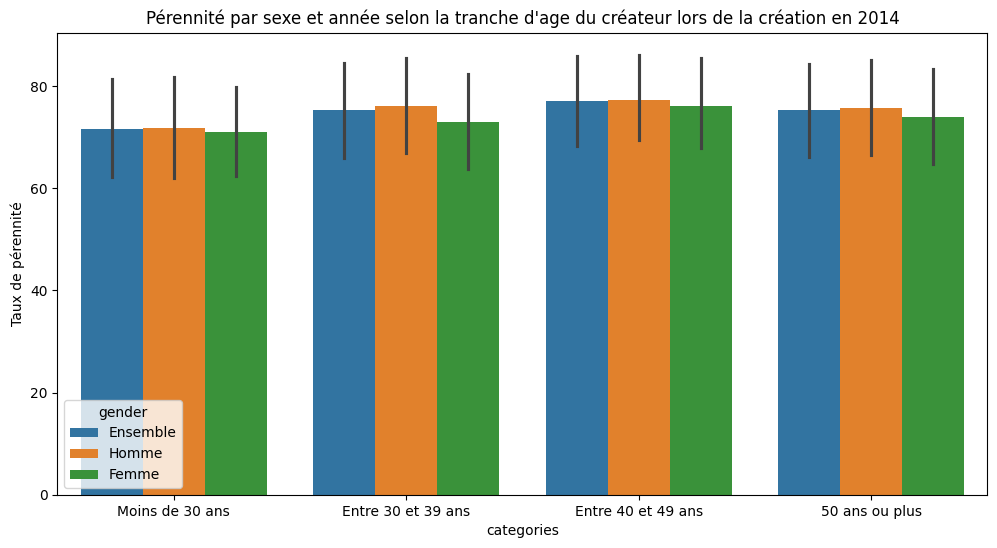

In [91]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_plot,
    x="categories", y="Taux de pérennité", hue="gender"
)

plt.title("Pérennité par sexe et année selon la tranche d'age du créateur lors de la création en 2014")
plt.show()

In [95]:
df_plot_2018 = df_2018[
    (df_2018["categorie_type"] == "Tranche d’âge du créateur en 2018") &
    (df_2018["area"] == "FR") &
    (df_2018["categories"] != "Ensemble")
].copy()

fig = px.bar(
    df_plot_2018,
    x="categories",
    y="Taux de pérennité (%)",
    color="gender",
    animation_frame="years",
    barmode="group",
    labels={"categories": "Tranche d'âge", "gender": "Genre"},
    title="Évolution de la pérennité selon le genre et la tranche d'âge",
)

fig.update_layout(
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    margin=dict(l=40, r=40, t=80, b=80)
)

fig.show()


In [82]:
# Dégradés simples
palette_femme = ["#006D2C", "#31A354", "#A1D99B"]  
palette_homme = ["#08306B", "#2171B5", "#6BAED6"]      
palette_ensemble = ["#99000D", "#CB181D", "#FB6A4A"]   

palettes = {
    "Femme": palette_femme,
    "Homme": palette_homme,
    "Ensemble": palette_ensemble,
}

In [83]:
fig = go.Figure()

# Boucle sur chaque genre
for genre in df_plot["gender"].unique():
    df_genre = df_plot[df_plot["gender"] == genre]
    palette = palettes.get(genre, ["gray", "gray", "gray"])  # fallback sécurité

    # Boucle sur chaque année (1, 2, 3 ans)
    for i, year in enumerate(sorted(df_genre["years"].unique())):
        df_year = df_genre[df_genre["years"] == year]

        fig.add_trace(go.Scatter(
            x=df_year["categories"],
            y=df_year["Taux de pérennité (%)"],
            mode="lines+markers",
            name=f"{genre} - {year}",
            line=dict(color=palette[i], width=2),
            marker=dict(color=palette[i]),
        ))

# Mise en forme
fig.update_layout(
    title="Taux de pérennité selon l'âge du créateur, le genre et l'ancienneté",
    xaxis_title="Tranche d'âge",
    yaxis_title="Taux de pérennité (%)",
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    legend_title="Genre - Année",
    template="plotly_white"
)

fig.show()


lecture du graph : on remarque ici que les femmes ont tendance à créer une entreprise qui perdure dans le temps, peu importe l'âge à laquelle elle créé son entreprise. Le plus haut taux de pérénité au bout de 3 ans reste cependant lorsque la tranche d'âge se trouve entre 40 et 49 ans. (hommes (51%) comme femmes (58%))

# Clean Data

objectif : regrouper datas pour former un seul dataframe complet pour le modèle Machine Learning

## Renommer les variables

On ne renomme que les variables communes aux 2 datasets

In [187]:
df_2014["categories"] = df_2014["categories"].str.replace("\n", " ", regex=False).str.strip()
df_2018["categories"] = df_2018["categories"].str.replace("\n", " ", regex=False).str.strip()
df_2014.columns = df_2014.columns.str.replace("\n", " ").str.strip()
df_2018.columns = df_2018.columns.str.replace("\n", " ").str.strip()

In [188]:
df_2018.rename(columns={"Taux de pérennité (%)" : "Taux de pérennité"}, inplace=True)

In [189]:
rename_2014 = {
    "Âge du créateur en 2014": "Tranche d'âge du créateur à la création",
    "Qualification préalable du créateur (PCS avant la\ncréation)": "Qualifications préalable du créateur",
    "Situation antérieure à la création": "Situation professionnelle au moment de la création",
    "Diplôme le plus élevé en 2014": "Diplôme le plus élevé à la création",
    "Nombre de créations ou reprises avant 2014": "Nombre de créations ou reprises au préalable",
    "Participation à une formation particulière pour la\nréalisation du projet": "Formation particulière suivie pour la création",
    "Bénéfice d'aides ou d'exonérations publiques": "Aides bénéficiées",
    "Situation familiale du créateur en 2014": "Situation personnelle au moment de la création"
}

rename_2018 = {
    "Tranche d’âge du créateur en 2018": "Tranche d'âge du créateur à la création",
    "Qualification préalable du créateur (PCS avant la\ncréation)": "Qualifications préalable du créateur",
    "Situation immédiate avant la création": "Situation professionnelle au moment de la création",
    "Diplôme le plus élevé du créateur": "Diplôme le plus élevé à la création",
    "création ou reprise d'une entreprise avant 2018\n(autre que entreprise actuelle)": "Nombre de créations ou reprises au préalable",
    "Suivi d'une formation particulière pour la\nréalisation du projet": "Formation particulière suivie pour la création",
    "Dispositifs d’aides dont a bénéficié le créateur": "Aides bénéficiées",
    "Situation personnelle du créateur": "Situation personnelle au moment de la création",
    "Durée de l’expérience dans le métier Principal": "Expérience du créateur dans le métier principal",
    "Secteur d’activité en 7 postes": "Secteur d'activité",
    "Principales raisons de choisir le régime de\nmicro-entrepreneur": "Motivations à la création",
    "Principales difficultés rencontrées pour mettre en\nplace le projet": "Principales difficultés rencontrées lors de la\ncréation",
}

In [190]:
df_2014["categorie_type"] = df_2014["categorie_type"].replace(rename_2014)
df_2018["categorie_type"] = df_2018["categorie_type"].replace(rename_2018)

In [100]:
df_2018.columns

Index(['gender', 'categorie_type', 'categories', 'years', 'Taux de pérennité',
       'Borne inférieure du taux de pérennité',
       'Borne supérieure du taux de pérennité', 'Nature des bornes',
       'file_name', 'area', 'year_source'],
      dtype='object')

## Filtrer les datasets

on ne garde que les variables utiles

In [191]:
df_2014 = df_2014.drop(columns=["Borne inférieure à 95\xa0% du taux de pérennité","Borne supérieure à 95\xa0% du taux de pérennité","file_name"])
df_2018 = df_2018.drop(columns=["Borne inférieure du taux de pérennité","Borne supérieure du taux de pérennité","Nature des bornes","file_name"])

In [192]:
def nettoyage_df(df):
    # Supprimer les lignes où le genre est "Ensemble"
    df = df[df["gender"] != "Ensemble"]
    df = df[df["categories"] != "Ensemble"]

    # Supprimer les lignes avec "4 ans" ou "5 ans" pour avoir uniquement les données sur 3 ans
    df = df[~df["years"].isin(["4 ans", "5 ans"])]

    # Nettoyer la colonne "years" pour extraire l'entier
    df["years"] = df["years"].str.extract(r"(\d)").astype(int)

    return df

In [193]:
df_2014 = nettoyage_df(df_2014)
df_2018 = nettoyage_df(df_2018)

filtres les datasets pour ne garder que les catégories qui sont présentes dans les 2 datasets

In [194]:
common_categorie_types = set(df_2014["categorie_type"].unique()) & set(df_2018["categorie_type"].unique())

df_2014 = df_2014[df_2014["categorie_type"].isin(common_categorie_types)]
df_2018 = df_2018[df_2018["categorie_type"].isin(common_categorie_types)]

## Regrouper les catégories trop détaillées

Certaines sous-catégories sont plus ou moins détaillées selon les années, il faut dont les regrouper pour avoir les mêmes bases

In [195]:
mapping_2014 = {
    "Volonté d'être indépendant": "Indépendance / liberté",
    "Goût d'entreprendre ou le désir d'affronter de nouveaux défis": "Indépendance / liberté",
    "Perspectives d'augmenter les revenus": "Revenus",
    "Opportunité": "Tester un projet",
    "Idée nouvelle de produit, de service, de marché": "Tester un projet",
    "Exemple réussi d'entrepreneurs dans l'entourage": "Tester un projet",
    "Sans emploi, par choix": "Créer son emploi",
    "Sans emploi, par contrainte": "Créer son emploi",
    "Seule possibilité pour exercer la profession": "Créer son emploi"
}

df_2014['categories'] = df_2014.apply(
    lambda row: mapping_2014[row['categories']] if row['categorie_type'] == "Motivations à la création" else row['categories'],
    axis=1
)

In [196]:
df_2018["categories"].unique()

array(['Moins de 30 ans', '30 à 39 ans', '40 à 49 ans', '50 ans et plus',
       'Seul', 'En couple', 'Aucun diplôme qualifiant', 'CAP, BEP',
       'Baccalauréat', 'Diplôme du supérieur de 1er cycle',
       'Diplôme du supérieur de 2e ou 3e cycle',
       'Indépendant, chef d’entreprise salarié, P.D.G.',
       'Agent de la fonction publique, Salarié du secteur privé, Intérimaire en CDD, Intermittent du spectacle',
       'Au chômage', 'Étudiant, Sans activité professionnelle, Retraité',
       'Même activité que le métier principal et aucune expérience',
       "Même activité que le métier principal et moins de 3 ans d'expérience",
       "Même activité que le métier principal et de 3 à 10 ans d'expérience",
       'Même activité que le métier principal et plus de 10 ans d’expérience',
       'Activité différente du métier principal', 'Oui', 'Non',
       'Industrie', 'Construction',
       'Commerce de gros et de détail, transports, hébergement et restauration',
       'Information

In [197]:
mapping_2018 = {
    "Créer votre entreprise": "Indépendance / liberté",
    "Maintenir une activité intellectuelle": "Indépendance / liberté",
    "Développer une activité de complément": "Revenus",
    "Tester un projet d'entreprise": "Tester un projet", 
    "Répondre à une opportunité ponctuelle": "Tester un projet",
    "Essentiellement assurer votre propre emploi": "Créer son emploi",
    "Régulariser votre activité": "Créer son emploi",
    "Travailler pour une plate-forme numérique de mise en relation": "Créer son emploi",
    "Travailler pour votre ancien employeur": "Créer son emploi"
}

mapping_secteur_2018 = {
    "Industrie": "Industrie et construction",
    "Construction": "Industrie et construction",
    "Commerce de gros et de détail, transports, hébergement et restauration": "Commerce, transport, hébergement",
    "Information et communication, activités immobilières, financières et d’assurance": "Services spécialisés et support",
    "Activités spécialisées, scientifiques et techniques et activités de services administratifs et de soutien": "Services spécialisés et support",
    "Enseignement, santé humaine et action sociale": "Santé, enseignement, social",
    "Autres activités de services": "Autres services"
}

df_2018['categories'] = df_2018.apply(
    lambda row: mapping_2018[row['categories']] if row['categorie_type'] == "Motivations à la création" else row['categories'],
    axis=1
)
df_2018['categories'] = df_2018.apply(
    lambda row: mapping_secteur_2018[row['categories']] if row['categorie_type'] == "Secteur d'activité" else row['categories'],
    axis=1
)


In [198]:
df_2014["categorie_type"] = (
    df_2014["categorie_type"]
    .str.replace("\n", " ", regex=False)
    .str.replace("\xa0", " ", regex=False)
    .str.strip()
)

df_2018["categorie_type"] = (
    df_2018["categorie_type"]
    .str.replace("\n", " ", regex=False)
    .str.replace("\xa0", " ", regex=False)
    .str.strip()
)

In [199]:
df_2018.columns

Index(['gender', 'categorie_type', 'categories', 'years', 'Taux de pérennité',
       'area', 'year_source'],
      dtype='object')

In [200]:
print(df_2014["categorie_type"].unique())

["Secteur d'activité" "Tranche d'âge du créateur à la création"
 'Situation professionnelle au moment de la création'
 'Diplôme le plus élevé à la création' 'Motivations à la création'
 'Nombre de créations ou reprises au préalable'
 'Formation particulière suivie pour la création' 'Aides bénéficiées'
 'Moyens financiers nécessaires pour démarrer'
 'Situation personnelle au moment de la création'
 'Principales difficultés rencontrées lors de la création'
 'Expérience du créateur dans le métier principal']


In [202]:
print("2014 : ", df_2014[df_2014["categorie_type"] == "Secteur d'activité"]["categories"].unique())
print("2018 : ", df_2018[df_2018["categorie_type"] == "Secteur d'activité"]["categories"].unique())

2014 :  ['Industrie et construction'
 'Commerce de gros et de détail, transports, hébergement et restauration'
 'Information-communication, finance-assurance, immobilier\xa0- activités scientifiques et techniques - services administratifs et de soutien'
 'Enseignement, santé humaine, action sociale et autres activités de services']
2018 :  ['Industrie et construction' 'Commerce, transport, hébergement'
 'Services spécialisés et support' 'Santé, enseignement, social'
 'Autres services']


renommer toutes les sous-catégories pour avoir la même nomenclature partout

In [203]:
secteur_activite = {
    "Commerce, transport, hébergement": "Commerce de gros et de détail, transports, hébergement et restauration",
    "Services spécialisés et support": "Information-communication, finance-assurance, immobilier\xa0- activités scientifiques et techniques - services administratifs et de soutien",
    "Santé, enseignement, social": "Enseignement, santé humaine, action sociale et autres activités de services",
    "Autres services": "Enseignement, santé humaine, action sociale et autres activités de services"
}

tranche_age = {
    "30 à 39 ans": "Entre 30 et 39 ans",
    "40 à 49 ans": "Entre 40 et 49 ans",
    "50 ans et plus": "50 ans ou plus"
}

situation_pro = {
    "Indépendant, chef d'entreprise": "Indépendant, chef d’entreprise salarié, P.D.G.",
    "Agent de la fonction publique, salarié du privé, intérimaire": "Agent de la fonction publique, Salarié du secteur privé, Intérimaire en CDD, Intermittent du spectacle",
    "Chômeur": "Au chômage",
    "Étudiant, sans activité professionnelle, retraité" : "Étudiant, Sans activité professionnelle, Retraité"
}

creation_entreprise = {
    "0 création": "Non",
    "1 création": "Oui",
    "2 créations ou plus": "Oui"
}

formations = {
    "Oui, à ma demande": "Oui",
    "Oui, parce que cette formation est imposée": "Oui"
}

aides = {
    "Bénéfice de l’ACCRE": "Oui",
    "Bénéfice d’une autre aide que l’ACCRE": "Oui",
    "Aucun dispositif d’aide": "Non"
}

#notons ici que les échelles ne sont pas les mêmes pour les deux années, et nous faisons un mapping le plus adéquat possible
moyens_financiers_2014 = {
    "Moins de 2 000 euros": "Moins de 1 000€",
    "De 2 000 euros à moins de 6 000 euros": "De 1 000€ à moins de 4 000€",
    "De 6 000 euros à moins de 16 000 euros": "4 000€ ou plus",
    "De 16 000 euros à moins de 80 000 euros": "4 000€ ou plus",
    "80 000 euros ou plus": "4 000€ ou plus"
}

moyens_financiers_2018 = {
    "Aucun": "Moins de 1 000€",
}

situation_perso = {
    "Vit en couple": "En couple",
    "Ne vit pas en couple": "Seul"
}

difficulte_2014 = {
    "Aucune difficulté particulière": "Aucune difficulté particulière",
    "Être seul comme entrepreneur": "Effectuer seul les démarches",
    "Embaucher du personnel qualifié": "Autres difficultés",
    "Établir des contacts avec la clientèle": "Etablir des contacts avec la clientèle",
    "Fixer le prix des produits et services": "Fixer le prix de vos produits et services",
    "Trouver un local approprié": "Trouver un local commercial approprié",
    "Ouvrir un compte bancaire professionnel": "Ouvrir un compte bancaire",
    "Choisir un statut ou un régime pour l'entreprise": "Connaître la législation en vigueur"
}

difficulte_2018 = {
    "Obtenir des renseignements, conseils, formations": "Autres difficultés",
    "Trouver une assurance": "Autres difficultés",
    "Régler les formations administratives": "Régler les formalités administratives"
}

experience = {
    "Même activité que le métier principal et aucune expérience": "Aucune expérience",
    "Même activité que le métier principal et moins de 3 ans d'expérience": "Moins de 3 ans",
    "Même activité que le métier principal et de 3 à 10 ans d'expérience": "De 3 à 10 ans",
    "Même activité que le métier principal et plus de 10 ans d’expérience": "Plus de 10 ans",
    "Activité différente du métier principal": "Aucune expérience"
}


def apply_category_mapping(df, mapping, target_categorie_type):
    df['categories'] = df.apply(
        lambda row: mapping.get(row['categories'], row['categories']) if row['categorie_type'] == target_categorie_type else row['categories'],
        axis=1
    )
    return df

In [204]:
df_2018 = apply_category_mapping(df_2018, secteur_activite, "Secteur d'activité")
df_2018 = apply_category_mapping(df_2018, tranche_age, "Tranche d'âge du créateur à la création")
df_2014 = apply_category_mapping(df_2014, situation_pro, "Situation professionnelle au moment de la création")
df_2014 = apply_category_mapping(df_2014, creation_entreprise, "Nombre de créations ou reprises au préalable")
df_2014 = apply_category_mapping(df_2014, formations, "Formation particulière suivie pour la création")
df_2018 = apply_category_mapping(df_2018, aides, "Aides bénéficiées")
df_2014 = apply_category_mapping(df_2014, moyens_financiers_2014, "Moyens financiers nécessaires pour démarrer")
df_2018 = apply_category_mapping(df_2018, moyens_financiers_2018, "Moyens financiers nécessaires pour démarrer")
df_2014 = apply_category_mapping(df_2014, situation_perso, "Situation personnelle au moment de la création")
df_2014 = apply_category_mapping(df_2014, difficulte_2014, "Principales difficultés rencontrées lors de la création")
df_2018 = apply_category_mapping(df_2018, difficulte_2018, "Principales difficultés rencontrées lors de la création")
df_2018 = apply_category_mapping(df_2018, experience, "Expérience du créateur dans le métier principal")


## Pivoter les df

pour que le dataset soit bien lu par le modèle de machine learning, nous allons passer toutes les catégories et sous catégories en colonnes

In [169]:
df_2018

,gender,categorie_type,categories,years,Taux de pérennité,area,year_source
18,Homme,Tranche d'âge du créateur à la création,Moins de 30 ans,1,67.2,FR,2018
19,Homme,Tranche d'âge du créateur à la création,Moins de 30 ans,2,47.7,FR,2018
20,Homme,Tranche d'âge du créateur à la création,Moins de 30 ans,3,33.5,FR,2018
21,Homme,Tranche d'âge du créateur à la création,Entre 30 et 39 ans,1,79.1,FR,2018
22,Homme,Tranche d'âge du créateur à la création,Entre 30 et 39 ans,2,59.8,FR,2018
...,...,...,...,...,...,...,...
18193,Femme,Aides bénéficiées,Oui,3,55.8,94,2018
18194,Femme,Aides bénéficiées,Oui,1,0.0,94,2018
18195,Femme,Aides bénéficiées,Oui,2,0.0,94,2018
18196,Femme,Aides bénéficiées,Oui,3,0.0,94,2018


In [205]:
def pivot (df):
    df_pivot = df.pivot_table(
        index=['gender', 'years', 'area', 'year_source'], 
        columns=['categorie_type', 'categories'],
        values='Taux de pérennité'
        ).reset_index()
    return df_pivot

In [206]:
df_2014_pivot = pivot(df_2014)
df_2018_pivot = pivot(df_2018)

In [207]:
df_2014_pivot

categorie_type gender years area year_source Aides bénéficiées        \
categories                                                 Non   Oui   
0               Femme     1   01        2014              87.2  90.5   
1               Femme     1   02        2014              88.4  83.2   
2               Femme     1   03        2014              84.3   0.0   
3               Femme     1   04        2014              78.5  84.8   
4               Femme     1   11        2014              95.2  88.9   
..                ...   ...  ...         ...               ...   ...   
103             Homme     3   76        2014              73.8  71.7   
104             Homme     3   84        2014              77.6  71.5   
105             Homme     3   93        2014              76.0  74.7   
106             Homme     3   94        2014              79.1  74.1   
107             Homme     3   FR        2014              75.7  72.4   

categorie_type Diplôme le plus élevé à la création                        \
categories                Aucun diplôme qualifiant Baccalauréat CAP, BEP   
0                                              0.0          0.0      0.0   
1                                              0.0          0.0      0.0   
2                                              0.0          0.0      0.0   
3                                             75.5         85.6     73.5   
4                                             91.2         92.0     91.3   
..                                             ...          ...      ...   
103                                           72.1         70.7     71.7   
104                                           69.5         75.5     69.4   
105                                           74.9         74.7     69.8   
106                                           79.4         76.8     75.3   
107                                           71.3         74.6     71.2   

categorie_type                                    ...  \
categories     Diplôme du supérieur de 1er cycle  ...   
0                                            0.0  ...   
1                                            0.0  ...   
2                                            0.0  ...   
3                                           87.1  ...   
4                                           93.0  ...   
..                                           ...  ...   
103                                         73.5  ...   
104                                         78.5  ...   
105                                         81.0  ...   
106                                         75.7  ...   
107                                         76.3  ...   

categorie_type Situation personnelle au moment de la création        \
categories                                          En couple  Seul   
0                                                        90.7  86.2   
1                                                        88.5  84.4   
2                                                        79.5  87.6   
3                                                        76.7  83.8   
4                                                        93.8  92.3   
..                                                        ...   ...   
103                                                      66.3  75.7   
104                                                      70.5  76.1   
105                                                      76.9  74.9   
106                                                      75.5  77.8   
107                                                      70.6  75.8   

categorie_type                                                     Situation professionnelle au moment de la création  \
categories     Agent de la fonction publique, Salarié du secteur privé, Intérimaire en CDD, Intermittent du spectacle   
0                                                             0.0                                                       
1                                            

In [208]:
df_2018_pivot

categorie_type gender years area year_source Aides bénéficiées         \
categories                                                 Non    Oui   
0               Femme     1   01        2018               0.0   0.00   
1               Femme     1   02        2018               0.0   0.00   
2               Femme     1   03        2018               0.0   0.00   
3               Femme     1   04        2018               0.0   0.00   
4               Femme     1   11        2018              71.8  76.25   
..                ...   ...  ...         ...               ...    ...   
103             Homme     3   76        2018              42.9  52.85   
104             Homme     3   84        2018              44.2  42.05   
105             Homme     3   93        2018              44.5  45.95   
106             Homme     3   94        2018              46.8  29.00   
107             Homme     3   FR        2018              42.5  43.65   

categorie_type Diplôme le plus élevé à la création                        \
categories                Aucun diplôme qualifiant Baccalauréat CAP, BEP   
0                                              0.0          0.0      0.0   
1                                              0.0          0.0      0.0   
2                                              0.0          0.0      0.0   
3                                              0.0          0.0      0.0   
4                                             77.4         70.7     72.0   
..                                             ...          ...      ...   
103                                           49.8         44.2     55.6   
104                                           47.3         46.2     48.8   
105                                           48.9         50.3     48.6   
106                                           56.9         51.3     57.7   
107                                           46.8         42.1     50.0   

categorie_type                                    ...  \
categories     Diplôme du supérieur de 1er cycle  ...   
0                                            0.0  ...   
1                                            0.0  ...   
2                                            0.0  ...   
3                                            0.0  ...   
4                                           78.5  ...   
..                                           ...  ...   
103                                         46.7  ...   
104                                         49.9  ...   
105                                         39.5  ...   
106                                         46.1  ...   
107                                         43.2  ...   

categorie_type Situation personnelle au moment de la création        \
categories                                          En couple  Seul   
0                                                         0.0   0.0   
1                                                         0.0   0.0   
2                                                         0.0   0.0   
3                                                         0.0   0.0   
4                                                        79.3  68.3   
..                                                        ...   ...   
103                                                      48.7  45.6   
104                                                      48.6  44.5   
105                                                      47.7  44.9   
106                                                      54.3  50.3   
107                                                      46.9  39.7   

categorie_type                                                     Situation professionnelle au moment de la création  \
categories     Agent de la fonction publique, Salarié du secteur privé, Intérimaire en CDD, Intermittent du spectacle   
0                                                             0.0                                                       
1                               

In [209]:
df_2018_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 51 columns):
 #   Column                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                          --------------  -----  
 0   (gender, )                                                                                                                                                      108 non-null    object 
 1   (years, )                                                                                                                                                       108 non-null    int64  
 2   (area, )                                                                                                                              

# Merge data

notons ici que les données 2018 ne sont pas complètes dans la première et deucième année après la création de l'entreprise. Nous avons uniquement les données nationale et non régionale. 
nous allons faire un filtre pour ne garder que les données nationales sur les 2 datasets, pour les 1ère et 2ème années après la création

In [210]:
def merge_dataset(df_2014, df_2018):

    df_total = pd.concat([df_2014, df_2018], ignore_index=True)
    
    df_filtered = df_total[
        (df_total["years"] == 3) |
        ((df_total["years"].isin([1, 2])) & (df_total["area"] == "FR"))
    ]
    
    return df_filtered

In [211]:
df_alldata = merge_dataset(df_2014_pivot, df_2018_pivot)

In [212]:
df_alldata["Secteur d'activité"]

categories,"Commerce de gros et de détail, transports, hébergement et restauration","Enseignement, santé humaine, action sociale et autres activités de services",Industrie et construction,"Information-communication, finance-assurance, immobilier - activités scientifiques et techniques - services administratifs et de soutien"
17,87.6,91.90,89.50,90.40
35,77.6,84.50,77.20,81.40
36,65.7,74.90,0.00,67.60
37,69.7,65.80,0.00,80.60
38,58.6,76.70,0.00,0.00
...,...,...,...,...
211,37.8,53.65,58.60,45.55
212,34.2,54.35,57.40,46.70
213,35.3,48.55,57.85,47.25
214,53.8,25.70,28.40,25.30


In [213]:
df_alldata

categorie_type gender years area year_source Aides bénéficiées         \
categories                                                 Non    Oui   
17              Femme     1   FR        2014              91.0  88.60   
35              Femme     2   FR        2014              82.5  78.50   
36              Femme     3   01        2014              67.4  74.10   
37              Femme     3   02        2014              77.3  68.00   
38              Femme     3   03        2014              68.6   0.00   
..                ...   ...  ...         ...               ...    ...   
211             Homme     3   76        2018              42.9  52.85   
212             Homme     3   84        2018              44.2  42.05   
213             Homme     3   93        2018              44.5  45.95   
214             Homme     3   94        2018              46.8  29.00   
215             Homme     3   FR        2018              42.5  43.65   

categorie_type Diplôme le plus élevé à la création                        \
categories                Aucun diplôme qualifiant Baccalauréat CAP, BEP   
17                                            87.1         90.0     87.3   
35                                            75.1         80.7     74.4   
36                                            70.6         64.1      0.0   
37                                             0.0          0.0      0.0   
38                                             0.0          0.0      0.0   
..                                             ...          ...      ...   
211                                           49.8         44.2     55.6   
212                                           47.3         46.2     48.8   
213                                           48.9         50.3     48.6   
214                                           56.9         51.3     57.7   
215                                           46.8         42.1     50.0   

categorie_type                                    ...  \
categories     Diplôme du supérieur de 1er cycle  ...   
17                                          90.9  ...   
35                                          81.9  ...   
36                                          77.6  ...   
37                                          84.0  ...   
38                                           0.0  ...   
..                                           ...  ...   
211                                         46.7  ...   
212                                         49.9  ...   
213                                         39.5  ...   
214                                         46.1  ...   
215                                         43.2  ...   

categorie_type Situation personnelle au moment de la création        \
categories                                          En couple  Seul   
17                                                       89.5  90.1   
35                                                       79.6  81.2   
36                                                       68.7  70.6   
37                                                       72.8  75.1   
38                                                       64.1  73.0   
..                                                        ...   ...   
211                                                      48.7  45.6   
212                                                      48.6  44.5   
213                                                      47.7  44.9   
214                                                      54.3  50.3   
215                                                      46.9  39.7   

categorie_type                                                     Situation professionnelle au moment de la création  \
categories     Agent de la fonction publique, Salarié du secteur privé, Intérimaire en CDD, Intermittent du spectacle   
17                                                           90.9                                                       
35                              

In [214]:
df_alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 17 to 215
Data columns (total 51 columns):
 #   Column                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                          --------------  -----  
 0   (gender, )                                                                                                                                                      80 non-null     object 
 1   (years, )                                                                                                                                                       80 non-null     int64  
 2   (area, )                                                                                                                                   